# Fast style transfer (1 to many)

Image-to-image translation has been an increasingly popular topic over the last years. One example of such a task is art style transfer. Style transfer algorithms in the context of art try to capture the general style of an artist or an image and apply it to one or many content pictures. As an example, think of your latest holiday picture and try to imagine how Monet or Van Gogh would have painted the scene. 

There are several different structures that try to do this task. One of the main differences is whether the style and content picture(s) are paired. A great paper to read to get started with style transfer is [Gatys et al. (2016)](https://openaccess.thecvf.com/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). In the below notebook I apply a faster alternative implementation that uses an encoder / decoder structure and uses a pre-trained Vgg19 model to compute the loss and train the model. 

__Instance normalization__ is a normalization method that seems to work particularly well for style transfer which is why we will use it in the below implementation. More information can be found in [Ulyanov and Vedaldi (2017)](https://arxiv.org/pdf/1607.08022.pdf).


Furthermore, I will use a perceptual loss as described in [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155).

In [1]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import random
import time

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

In [2]:
# #Show all files
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
# Paths et cetera
path_save_up_to_5gb = '/kaggle/working/'
path_monet = '../input/gan-getting-started/monet_jpg/'
path_photo = '../input/gan-getting-started/photo_jpg/'
img_size = 256

In [4]:
#Select device based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Helper functions

In [5]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)

In [6]:
def save_checkpoint(iteration, G_XtoYcheckpoint_dir='/kaggle/working/'):
    """
    Saves the parameters of both generators and discriminators.
    """
    #Path
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    #Saving
    torch.save(G_XtoY.state_dict(), G_XtoY_path)

In [7]:
def load_checkpoint(checkpoint_path, map_location=None):
    """
    Load checkoint
    """
    #model.load_state_dict(torch.load(checkpoint_path))
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % checkpoint_path)
    return checkpoint

In [8]:
def reverse_normalize(image, mean_=0.5, std_=0.5):
    if torch.is_tensor(image):
        image = image.detach().numpy()
    un_normalized_img = image * std_ + mean_
    un_normalized_img = un_normalized_img * 255
    return np.uint8(un_normalized_img)

In [9]:
def im_convert(tensor):
    """ Display a tensor as image"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    
    return image

In [10]:
def show_test(style_img, content_img, G_XtoY):
    
    #Moves fake_Y (target) to GPU, if available
    if torch.cuda.is_available():
        style_img = style_img.to(device)
        content_img = content_img.to(device)
    
    #Generate fake photo
    fake_Y = G_XtoY(content_img)
    
    #Moves fake_Y (target) to GPU, if available
    if torch.cuda.is_available():
        fake_Y = fake_Y.to(device)
    
    #Transformation from X -> Y
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, 10))
    
    #Image
    ax1.imshow(im_convert(style_img))
    ax2.imshow(im_convert(content_img))
    ax3.imshow(im_convert(fake_Y))
    
    #Grid
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    
    #Title
    ax1.set_title('Style')
    ax2.set_title('Content')
    ax3.set_title('Style transfer')
    
    #To do
    plt.show()

In [11]:
class ImageDataset(Dataset):
        """
        Custom dataset
        """
        
        def __init__(self, img_path, img_size=256, normalize=True):
            self.img_path = img_path
            
            if normalize:
                self.transform = transforms.Compose([
                    transforms.Resize(img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], std=[0.5])
                ])
            else:
                self.transform = transforms.Compose([
                    transforms.Resize(img_size),
                    transforms.ToTensor()
                ])
            
            #Dictionary entries
            self.img_idx = dict()
            for number_, img_ in enumerate(os.listdir(self.img_path)):
                self.img_idx[number_] = img_
                
        def __len__(self):
            #Length of dataset --> number of images
            return len(self.img_idx)
        
        def __getitem__(self, idx):
            img_path = os.path.join(self.img_path, self.img_idx[idx])
            img = Image.open(img_path)
            img = self.transform(img)
            
            return img

# Selecting style / content pictures

In [12]:
#Create normalized datasets
dataset_monet = ImageDataset(path_monet, img_size=256, normalize=True)
dataset_photo = ImageDataset(path_photo, img_size=256, normalize=True)

In [13]:
#Create test loaders
batch_size_style = 1
batch_size_content = 1
style_loader_Y = DataLoader(dataset_monet, batch_size=batch_size_style, shuffle=False, num_workers=0, pin_memory=True)
content_loader_X = DataLoader(dataset_photo, batch_size=batch_size_content, shuffle=False, num_workers=0, pin_memory=True)

In [14]:
#Dataiter
dataiter_style = iter(style_loader_Y)
dataiter_content = iter(content_loader_X)

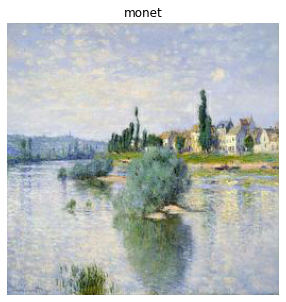

In [342]:
#Check dataset & dataloader results
style_img = dataiter_style.next()
style_img_show = im_convert(style_img)
fig = plt.figure(figsize=(5, 5))
plt.imshow(style_img_show)
plt.axis('off')
plt.title('monet')
plt.show()

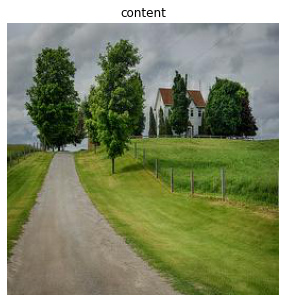

In [545]:
#Check dataset & dataloader results
content_img = dataiter_content.next()
content_img_show = im_convert(content_img)
fig = plt.figure(figsize=(5, 5))
plt.imshow(content_img_show)
plt.axis('off')
plt.title('content')
plt.show()

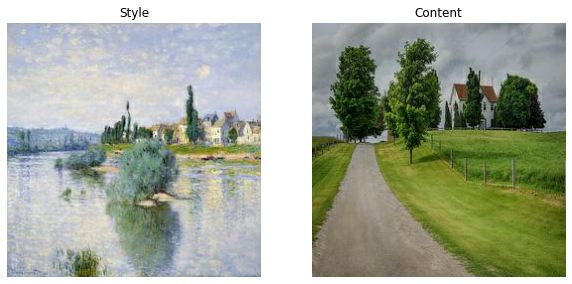

In [546]:
#Transformation next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
ax1.imshow(style_img_show)
ax1.axis('off')
ax1.set_title('Style')
ax2.imshow(content_img_show)
ax2.axis('off')
ax2.set_title('Content')
plt.show()

# Load pre-trained Vgg19

In [547]:
#get the "features" portion of VGG19 (we will not need the "classifier" portion)
loss_model = models.vgg19(pretrained=True).features

#Freeze all VGG parameters since we're only optimizing the target image
for param in loss_model.parameters():
    param.requires_grad_(False)

In [548]:
#Move model to device available
loss_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Feature extraction

In [549]:
def get_features(image, model, layers=None):
    """ 
    Run an image forward through a model and get the features for a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1', #style
                  '5': 'conv2_1', #style
                  '10': 'conv3_1', #style
                  '19': 'conv4_1', #style
                  '21': 'conv4_2', #content
                  '28': 'conv5_1'} #style
    
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [550]:
def gram_matrix(tensor):
    """ 
    Calculate the Gram Matrix of a given tensor 
    Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    #get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    #reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    #calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

# Encoder / decoder --> Generator

In [551]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, instance_norm=True):
    """
    Creates a convolutional layer, with optional instance normalization. 
    """
    
    #Add layers
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    layers.append(conv_layer)
    
    #Instance normalization
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [552]:
class ResidualBlock(nn.Module):

    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        """
        Residual blocks help the model to effectively learn the transformation from one domain to another. 
        """
        self.conv1 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, instance_norm=True)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, instance_norm=True)
        
    def forward(self, x):
        out_1 = F.relu(self.conv1(x))
        out_2 = x + self.conv2(out_1)
        return out_2

In [553]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, output_padding=0, instance_norm=True, dropout=False, dropout_ratio=0.5):
    """
    Creates a transpose convolutional layer, with optional batch / instance normalization. Select either batch OR instance normalization. 
    """
    
    #Add layers
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, bias=False))
    
    #Instance normalization
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    
    #Dropout
    if dropout:
        layers.append(nn.Dropout2d(dropout_ratio))
    
    return nn.Sequential(*layers)

In [554]:
class Generator(nn.Module):
    
    def __init__(self, conv_dim=32, n_res_blocks=5):
        super(Generator, self).__init__()
        """
        Input is RGB image (256x256x3) while output is a single value
        
        determine size = [(W−K+2P)/S]+1
        W: input=256
        K: kernel_size=4
        P: padding=1
        S: stride=2
        """
        
        #Encoder layers
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=9, stride=1, padding=4, instance_norm=True) # (256, 256, 32)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=3, stride=2, padding=1, instance_norm=True) # (128, 128, 64)
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=3, stride=2, padding=1, instance_norm=True) # (64, 64, 128)
        
        #Residual blocks (number depends on input parameter)
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4)) #(64, 64, 128)
        self.res_blocks = nn.Sequential(*res_layers)
        
        #Decoder layers
        self.deconv1 = deconv(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=3, stride=2, padding=1, output_padding=1, instance_norm=True) # (128, 128, 64)
        self.deconv2 = deconv(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1, instance_norm=True) # (256, 256, 32)
        self.deconv3 = deconv(in_channels=conv_dim, out_channels=3, kernel_size=9, stride=1, padding=4, instance_norm=True) # (256, 256, 3)
        
    def forward(self, x):
        """
        Given an image x, returns a transformed image.
        """
        
        #Encoder
        out = F.leaky_relu(self.conv1(x), negative_slope=0.1) # (256, 256, 32)
        out = F.leaky_relu(self.conv2(out), negative_slope=0.1) # (128, 128, 64)
        out = F.leaky_relu(self.conv3(out), negative_slope=0.1) # (64, 64, 128)
        
        #Residual blocks
        out = self.res_blocks(out) #(64, 64, 128)
        
        #Decoder
        out = F.leaky_relu(self.deconv1(out), negative_slope=0.1) # (128, 128, 64)
        out = F.leaky_relu(self.deconv2(out), negative_slope=0.1) # (256, 256, 32)
        out = torch.tanh(self.deconv3(out)) # (256, 256, 3)
        
        return out

In [555]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution with mean = 0, std dev = 0.02.
    Param m: A module or layer in a network    
    """
    #classname will be something like: `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    #normal distribution with given paramters
    std_dev = 0.02
    mean = 0.0
    
    # Initialize conv layer
    if hasattr(m, 'weight') and (classname.find('Conv') != -1):
        init.normal_(m.weight.data, mean, std_dev)

In [591]:
def build_model(g_conv_dim=32, n_res_blocks=6):
    """
    Builds models and moves them to correct device
    """
    
    #Generator
    G_XtoY = Generator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    
    #Weight initialization
    G_XtoY.apply(weights_init_normal)
    
    #Moves models to GPU, if available
    if torch.cuda.is_available():
        G_XtoY.to(device)
        print('Model moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY

In [592]:
#Build models
G_XtoY = build_model()

Model moved to GPU.


In [593]:
#Check model structure
print(G_XtoY)

Generator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(

# Loss function

In [594]:
def perceptual_loss(target, content_features, style_features, loss_model, style_weights, content_weights, alpha_weight, beta_weight):
    """
    Calculates loss for target picture with style and content images
    """
    
    #calculate the gram matrices for each layer of our style representation
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    
    #get the features from your target image
    target_features = get_features(target, loss_model)
    
    # =========================================
    # Content loss 
    # =========================================
    
    #initialize the content loss to 0
    content_loss = 0.0
    
    #Loop through each layer
    for layer in content_weights:
        
        #the content loss for one layer, weighted appropriately
#         layer_content_loss = content_weights[layer] * torch.mean((target_features[layer] - content_features[layer])**2)
        layer_content_loss = content_weights[layer] * torch.mean(torch.abs(target_features[layer] - content_features[layer]))
        
        #add to content loss
        content_loss += layer_content_loss / len(content_weights)
    
    # =========================================
    # Style loss 
    # =========================================
    
    #initialize the style loss to 0
    style_loss = 0.0
    
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        
        #get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        #get the "style" representation
        style_gram = style_grams[layer]
        
        #the style loss for one layer, weighted appropriately
#         layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        layer_style_loss = style_weights[layer] * torch.mean(torch.abs(target_gram - style_gram))
        
        #add to style loss
        style_loss += layer_style_loss / (d * h * w)
    
    # =========================================
    # Perceptual loss 
    # =========================================
    
    #calculate the total loss
    perceptual_loss = alpha_weight * content_loss + beta_weight * style_loss
    
    return perceptual_loss, alpha_weight * content_loss, beta_weight * style_loss

# Optimizer & feature weighting

In [595]:
import torch.optim as optim

#hyperparameter
lr=0.0005 ##0.0002
beta1=0.500 #exponential decay rate for the first moment estimates
beta2=0.999 #exponential decay rate for the second-moment estimates

#Optimizers for generator and discriminator
g_optimizer = optim.Adam(G_XtoY.parameters(), lr, [beta1, beta2])

In [596]:
#Weighting scheme for each layer
style_weights = {'conv1_1': 0.90, #0.90
                 'conv2_1': 0.75, #0.75
                 'conv3_1': 0.50, #0.50
                 'conv4_1': 0.25, #0.25
                 'conv5_1': 0.10} #0.10
content_weights = {'conv4_2': 0.99}

#Content vs. style
alpha_weight = 1.0e1  # content_weight
beta_weight = 1.0e4  # style_weight
print(alpha_weight / beta_weight)

0.001


# Training

In [597]:
def training_loop(style_img, content_img, n_epochs=1000):
    """
    trains generator to transform any image to required style
    loss_model, style_weights, content_weights, alpha_weight and beta_weight defined outside of function
    
    """
    
    #Start training time
    start = time.time()
    
    #Admin parameters
    print_every = 100
    show_every = 1000
    checkpoint_every = 5
    
#     #Create loaders if multiple images need to be changed (1 to many)
#     batch_size_content = 1
#     content_loader_X = DataLoader(dataset_photo, batch_size=batch_size_content, shuffle=True, num_workers=0, pin_memory=True)
#     dataiter_content = iter(content_loader_X)
#     batches_per_epoch = len(dataiter_content) // batch_size_content
#     content_img = dataiter_content.next()
    
    #Moves images to GPU, if available
    if torch.cuda.is_available():
        style_img = style_img.to(device)
        content_img = content_img.to(device)
    
    #Losses over time
    losses = []
    
    #get content and style features only once before forming the target image
    content_features = get_features(content_img, loss_model)
    style_features = get_features(style_img, loss_model)
    
    #run training loop
    for epoch in range(1, n_epochs+1):
        
        #Back to the start
        g_optimizer.zero_grad()
        
        #transformation
        fake_Y = G_XtoY(content_img)
        
        #Moves fake_Y (target) to GPU, if available
        if torch.cuda.is_available():
            fake_Y.to(device)
        
        #perceptual_loss
        total_perceptual_loss, content_loss, style_loss = perceptual_loss(fake_Y, content_features, style_features, loss_model, style_weights, content_weights, alpha_weight, beta_weight)
        
        #Optimization step
        total_perceptual_loss.backward()
        g_optimizer.step()
        
        # =========================================
        # Admin 
        # =========================================
        
        #Get time since started
        end = time.time()
        elapsed = end - start #in seconds
        elapsed = elapsed/60.0
        
        #print log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((content_loss.item(), style_loss.item(), total_perceptual_loss.item()))
            print('Epoch [{:5d}/{:5d}] | minutes since start: {:6.2f} | content_loss: {:6.4f} | style_loss: {:6.4f} | total_perceptual_loss: {:6.4f}'.format(
                    epoch, n_epochs, elapsed, content_loss.item(), style_loss.item(), total_perceptual_loss.item()))
        
        #show the generated samples
        if epoch % show_every == 0:
            #set generator to eval mode for image generation
            G_XtoY.eval()
            test_images = show_test(style_img, content_img, G_XtoY)
            #set generator to train mode to continue training
            G_XtoY.train()
            
#         #save the model parameters
#         if epoch % checkpoint_every == 0:
#             save_checkpoint(epoch, G_XtoY)
    
    return losses

Epoch [  100/ 6000] | minutes since start:   0.12 | content_loss: 5.5235 | style_loss: 7.8451 | total_perceptual_loss: 13.3686
Epoch [  200/ 6000] | minutes since start:   0.24 | content_loss: 3.6316 | style_loss: 4.7820 | total_perceptual_loss: 8.4137
Epoch [  300/ 6000] | minutes since start:   0.36 | content_loss: 2.8306 | style_loss: 3.4895 | total_perceptual_loss: 6.3202
Epoch [  400/ 6000] | minutes since start:   0.48 | content_loss: 2.6151 | style_loss: 3.4002 | total_perceptual_loss: 6.0153
Epoch [  500/ 6000] | minutes since start:   0.60 | content_loss: 2.3285 | style_loss: 3.0790 | total_perceptual_loss: 5.4075
Epoch [  600/ 6000] | minutes since start:   0.72 | content_loss: 2.2518 | style_loss: 3.0466 | total_perceptual_loss: 5.2984
Epoch [  700/ 6000] | minutes since start:   0.84 | content_loss: 2.0482 | style_loss: 3.0895 | total_perceptual_loss: 5.1377
Epoch [  800/ 6000] | minutes since start:   0.96 | content_loss: 1.9361 | style_loss: 2.8743 | total_perceptual_loss

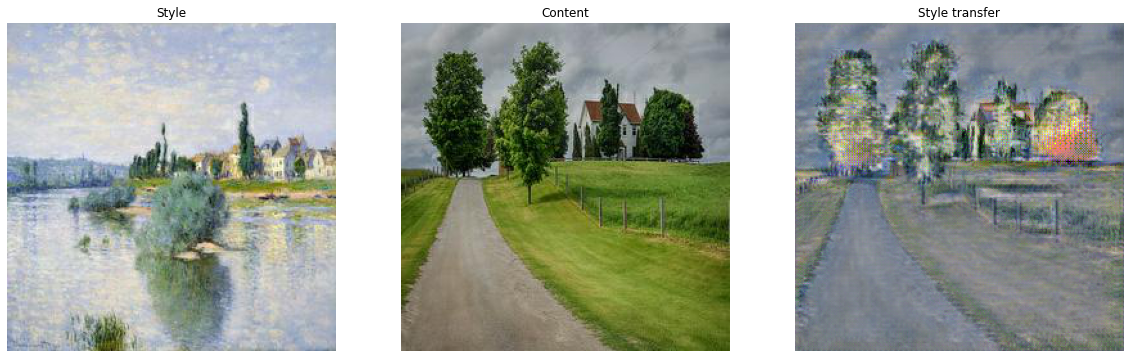

Epoch [ 1100/ 6000] | minutes since start:   1.32 | content_loss: 1.8430 | style_loss: 2.7720 | total_perceptual_loss: 4.6150
Epoch [ 1200/ 6000] | minutes since start:   1.44 | content_loss: 1.8703 | style_loss: 2.8243 | total_perceptual_loss: 4.6946
Epoch [ 1300/ 6000] | minutes since start:   1.56 | content_loss: 1.7616 | style_loss: 2.7528 | total_perceptual_loss: 4.5144
Epoch [ 1400/ 6000] | minutes since start:   1.68 | content_loss: 2.3421 | style_loss: 3.4848 | total_perceptual_loss: 5.8269
Epoch [ 1500/ 6000] | minutes since start:   1.80 | content_loss: 1.6956 | style_loss: 2.7379 | total_perceptual_loss: 4.4335
Epoch [ 1600/ 6000] | minutes since start:   1.92 | content_loss: 1.6274 | style_loss: 2.6634 | total_perceptual_loss: 4.2908
Epoch [ 1700/ 6000] | minutes since start:   2.04 | content_loss: 1.6098 | style_loss: 2.7338 | total_perceptual_loss: 4.3436
Epoch [ 1800/ 6000] | minutes since start:   2.16 | content_loss: 1.6194 | style_loss: 2.6198 | total_perceptual_loss:

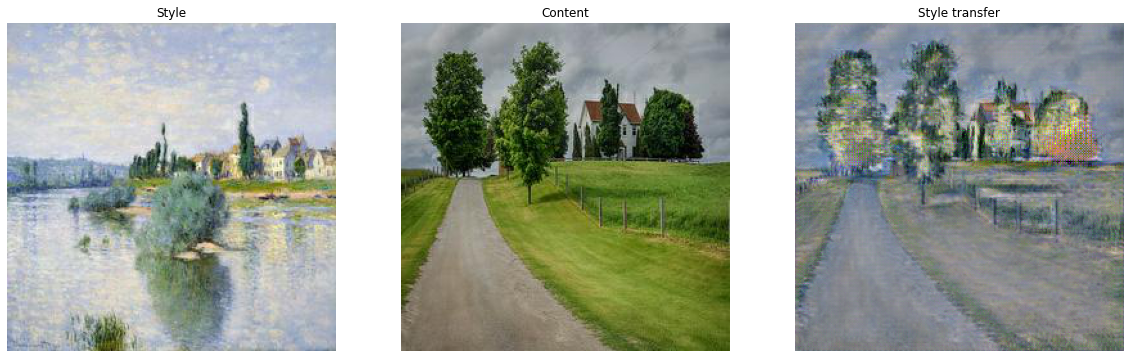

Epoch [ 2100/ 6000] | minutes since start:   2.52 | content_loss: 1.5668 | style_loss: 2.7832 | total_perceptual_loss: 4.3501
Epoch [ 2200/ 6000] | minutes since start:   2.64 | content_loss: 1.5121 | style_loss: 2.6976 | total_perceptual_loss: 4.2097
Epoch [ 2300/ 6000] | minutes since start:   2.76 | content_loss: 1.4962 | style_loss: 2.6563 | total_perceptual_loss: 4.1525
Epoch [ 2400/ 6000] | minutes since start:   2.88 | content_loss: 5.5408 | style_loss: 6.3685 | total_perceptual_loss: 11.9093
Epoch [ 2500/ 6000] | minutes since start:   3.00 | content_loss: 2.0973 | style_loss: 3.0748 | total_perceptual_loss: 5.1721
Epoch [ 2600/ 6000] | minutes since start:   3.12 | content_loss: 1.7809 | style_loss: 3.1269 | total_perceptual_loss: 4.9078
Epoch [ 2700/ 6000] | minutes since start:   3.24 | content_loss: 1.6791 | style_loss: 2.7862 | total_perceptual_loss: 4.4653
Epoch [ 2800/ 6000] | minutes since start:   3.36 | content_loss: 1.5755 | style_loss: 2.7817 | total_perceptual_loss

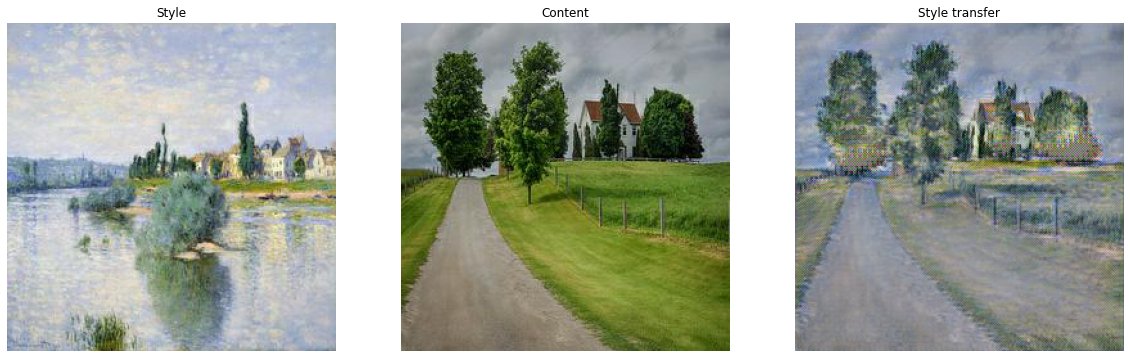

Epoch [ 3100/ 6000] | minutes since start:   3.73 | content_loss: 1.4598 | style_loss: 2.7101 | total_perceptual_loss: 4.1699
Epoch [ 3200/ 6000] | minutes since start:   3.85 | content_loss: 1.4165 | style_loss: 2.7248 | total_perceptual_loss: 4.1413
Epoch [ 3300/ 6000] | minutes since start:   3.97 | content_loss: 1.4114 | style_loss: 2.6988 | total_perceptual_loss: 4.1102
Epoch [ 3400/ 6000] | minutes since start:   4.09 | content_loss: 1.3957 | style_loss: 2.5994 | total_perceptual_loss: 3.9951
Epoch [ 3500/ 6000] | minutes since start:   4.21 | content_loss: 1.3964 | style_loss: 2.5706 | total_perceptual_loss: 3.9670
Epoch [ 3600/ 6000] | minutes since start:   4.33 | content_loss: 1.4183 | style_loss: 2.5940 | total_perceptual_loss: 4.0124
Epoch [ 3700/ 6000] | minutes since start:   4.44 | content_loss: 1.3809 | style_loss: 2.6300 | total_perceptual_loss: 4.0109
Epoch [ 3800/ 6000] | minutes since start:   4.56 | content_loss: 1.3172 | style_loss: 2.6172 | total_perceptual_loss:

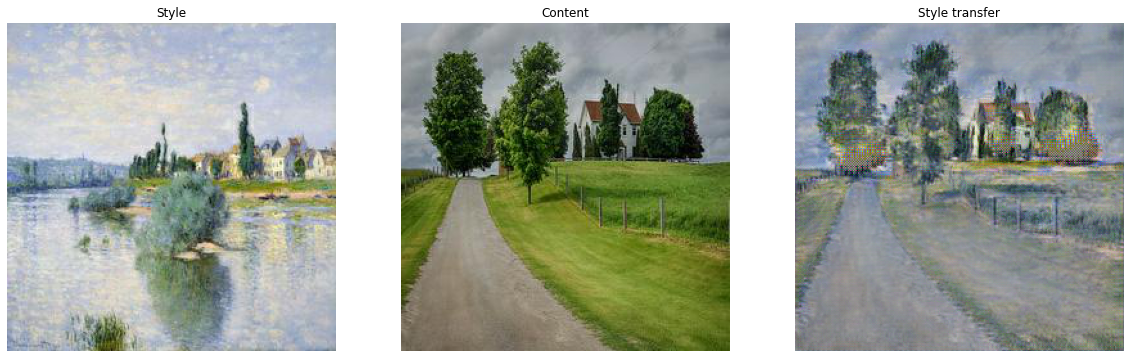

Epoch [ 4100/ 6000] | minutes since start:   4.93 | content_loss: 1.6469 | style_loss: 2.9716 | total_perceptual_loss: 4.6185
Epoch [ 4200/ 6000] | minutes since start:   5.05 | content_loss: 1.3704 | style_loss: 2.5389 | total_perceptual_loss: 3.9093
Epoch [ 4300/ 6000] | minutes since start:   5.17 | content_loss: 1.3300 | style_loss: 2.5469 | total_perceptual_loss: 3.8769
Epoch [ 4400/ 6000] | minutes since start:   5.29 | content_loss: 1.3286 | style_loss: 2.5483 | total_perceptual_loss: 3.8769
Epoch [ 4500/ 6000] | minutes since start:   5.41 | content_loss: 1.3168 | style_loss: 2.5149 | total_perceptual_loss: 3.8317
Epoch [ 4600/ 6000] | minutes since start:   5.53 | content_loss: 1.2776 | style_loss: 2.5899 | total_perceptual_loss: 3.8675
Epoch [ 4700/ 6000] | minutes since start:   5.65 | content_loss: 1.2978 | style_loss: 2.5396 | total_perceptual_loss: 3.8374
Epoch [ 4800/ 6000] | minutes since start:   5.77 | content_loss: 1.3133 | style_loss: 2.5139 | total_perceptual_loss:

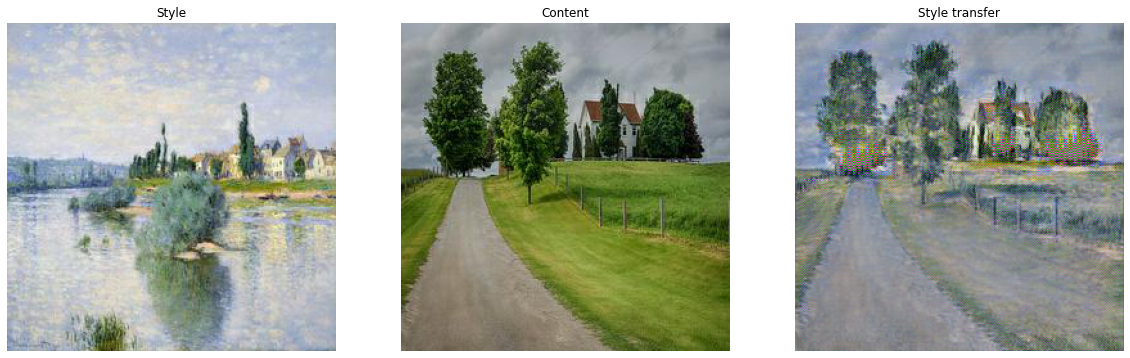

Epoch [ 5100/ 6000] | minutes since start:   6.14 | content_loss: 1.2927 | style_loss: 2.4928 | total_perceptual_loss: 3.7855
Epoch [ 5200/ 6000] | minutes since start:   6.26 | content_loss: 1.3095 | style_loss: 2.5373 | total_perceptual_loss: 3.8467
Epoch [ 5300/ 6000] | minutes since start:   6.38 | content_loss: 1.2651 | style_loss: 2.5098 | total_perceptual_loss: 3.7749
Epoch [ 5400/ 6000] | minutes since start:   6.50 | content_loss: 1.2782 | style_loss: 2.5839 | total_perceptual_loss: 3.8621
Epoch [ 5500/ 6000] | minutes since start:   6.62 | content_loss: 1.2814 | style_loss: 2.4889 | total_perceptual_loss: 3.7704
Epoch [ 5600/ 6000] | minutes since start:   6.74 | content_loss: 1.2788 | style_loss: 2.4993 | total_perceptual_loss: 3.7782
Epoch [ 5700/ 6000] | minutes since start:   6.85 | content_loss: 1.5280 | style_loss: 2.6731 | total_perceptual_loss: 4.2012
Epoch [ 5800/ 6000] | minutes since start:   6.97 | content_loss: 1.2815 | style_loss: 2.5290 | total_perceptual_loss:

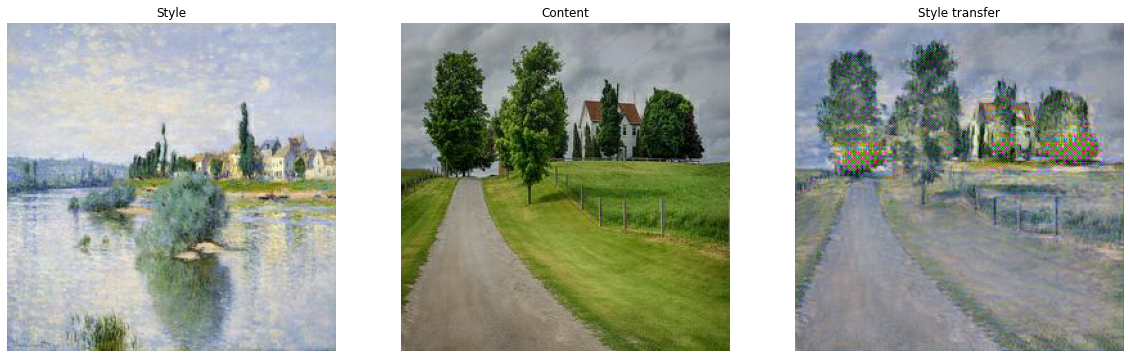

In [598]:
#Go train!
losses = training_loop(style_img, content_img, n_epochs=6000)

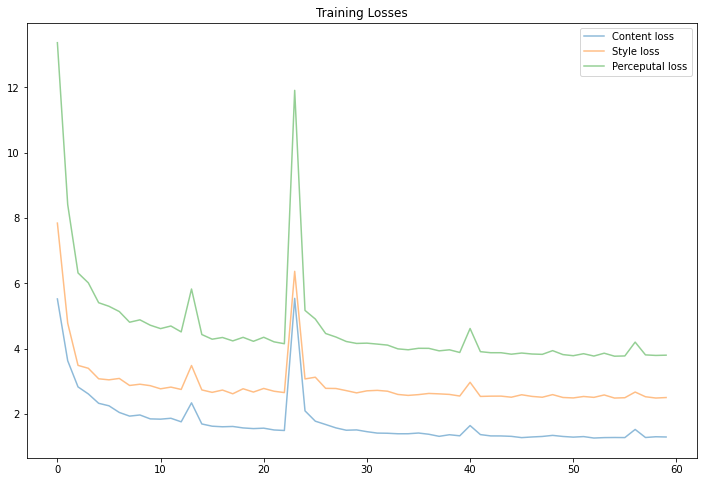

In [599]:
#Plot loss functions over training
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Content loss', alpha=0.5)
plt.plot(losses.T[1], label='Style loss', alpha=0.5)
plt.plot(losses.T[2], label='Perceputal loss', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()

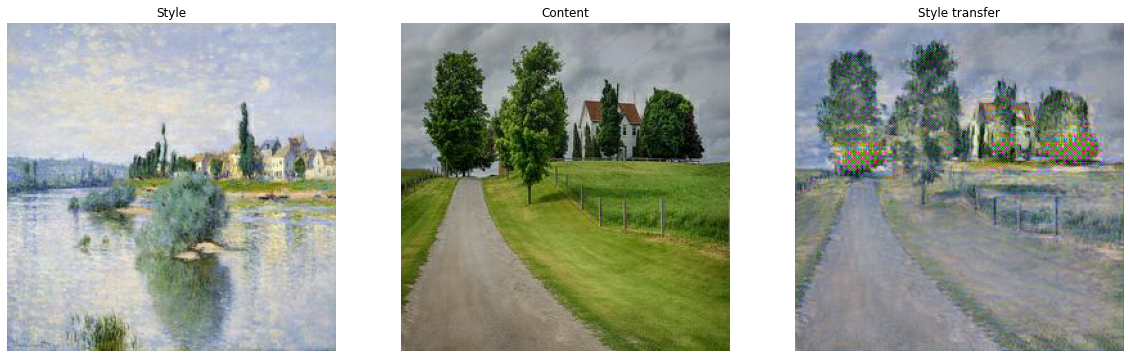

In [600]:
G_XtoY.eval()
test_images = show_test(style_img, content_img, G_XtoY)